## Getting Started
First generating some test data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from annotation_driven_dataframe_calcs.annotation_driven_dataframe_calcs import expand_for_timesteps
from annotation_driven_dataframe_calcs.column_names import TIMESTEP_NO, ACCOUNT_NO, PARAM_C, PARAM_B, PARAM_A, SERIES_A_PRIME
from annotation_driven_dataframe_calcs.registry import register
from annotation_driven_dataframe_calcs.calculation_helpers import nonrecursive_calculation, recursive_calculation, calculate_over_window, integrated_nonrecursive_calculation, integrated_recursive_calculation

fake_data = pd.DataFrame({
    ACCOUNT_NO: [1, 2, 3, 4],
    PARAM_A: [201908, 201907, 201906, 201905],
    PARAM_B: [10, 15, 20, 25],
    PARAM_C: [5, 6, 7, 8]
})

2020-12-19 17:49:47.222 | DEBUG    | annotation_driven_dataframe_calcs.registry:<module>:11 - Creating the registry
2020-12-19 17:49:47.223 | DEBUG    | annotation_driven_dataframe_calcs.registry:<module>:13 - Registry created


In [3]:
result = expand_for_timesteps(fake_data, 1, 3)
result

COLUMN_A  COLUMN_B  COLUMN_C
ACCT_NO TIMESTEP_NO                              
1       1              201908        10         5
        2              201908        10         5
        3              201908        10         5
2       1              201907        15         6
        2              201907        15         6
        3              201907        15         6
3       1              201906        20         7
        2              201906        20         7
        3              201906        20         7
4       1              201905        25         8
        2              201905        25         8
        3              201905        25         8

Let's register some series to be calculated.

First a non-recursive calculation.

In [4]:
@register(output_series_name='TEST_OUTPUT_C')
@calculate_over_window(
    series_to_run_window_over=PARAM_A,
    window_size=2,
    output_series_name='TEST_OUTPUT_C'
)
@nonrecursive_calculation
def new_core_arithmetric_for_series_b_prime(
    account_no,
    timestep_no,
    current_window_series,
    entire_input_data_set,
) -> float:
    return (
        - entire_input_data_set.loc[(account_no, timestep_no), PARAM_B]
        - entire_input_data_set.loc[(account_no, timestep_no), PARAM_C]
    )

2020-12-19 17:49:53.174 | INFO     | annotation_driven_dataframe_calcs.registry:register:32 - Registering series TEST_OUTPUT_C and its dependencies []


Second recursive calculation

In [5]:
@register(output_series_name=f"{SERIES_A_PRIME}_FROM_DECS")
@calculate_over_window(
    series_to_run_window_over=PARAM_A,
    window_size=2,
    output_series_name=f"{SERIES_A_PRIME}_FROM_DECS"
)
@recursive_calculation(
    number_of_previous_terms_needed=1,
    tuple_of_initial_values=(100,)
)
def series_c_prime(
    account_no,
    timestep_no,
    current_window_series,
    tuple_of_previous_calculated_values,
    entire_input_data_set,
) -> float:
    return (
        tuple_of_previous_calculated_values[0]
        - entire_input_data_set.loc[(account_no, timestep_no), PARAM_B]
        - entire_input_data_set.loc[(account_no, timestep_no), PARAM_C]
    )

2020-12-19 17:49:55.703 | INFO     | annotation_driven_dataframe_calcs.registry:register:32 - Registering series SERIES_A_PRIME_FROM_DECS and its dependencies []


Let's also try using the integrated decorator that wraps all the functionality of registering and adapting the function's signatre.

In [6]:
@integrated_nonrecursive_calculation(
    output_series_name='TEST_OUTPUT_D',
    series_to_run_window_over=PARAM_A,
    window_size=2
)
def series_d_prime(
    account_no,
    timestep_no,
    current_window_series,
    entire_input_data_set,
) -> float:
    return (
       50 - entire_input_data_set.loc[(account_no, timestep_no), PARAM_B]
        - entire_input_data_set.loc[(account_no, timestep_no), PARAM_C]
    )

2020-12-19 17:49:58.196 | INFO     | annotation_driven_dataframe_calcs.registry:register:32 - Registering series TEST_OUTPUT_D and its dependencies []


Finally, let's use the integrated decorator for recursive calculations and have it depend on the values of previously calculated series.

In [8]:
@integrated_recursive_calculation(
    output_series_name='SUPER_SERIES_D',
    depends_on_calculated_input_series=['TEST_OUTPUT_D', f"{SERIES_A_PRIME}_FROM_DECS"],
    series_to_run_window_over=PARAM_A,
    window_size=2,
    number_of_previous_terms_needed=1,
    tuple_of_initial_values=(0,)
)
def series_c_prime(
    account_no,
    timestep_no,
    current_window_series,
    tuple_of_previous_calculated_values,
    entire_input_data_set,
) -> float:
    return tuple_of_previous_calculated_values[0] -((
         entire_input_data_set.loc[(account_no, timestep_no), f"{SERIES_A_PRIME}_FROM_DECS"]
    )/entire_input_data_set.loc[(account_no, timestep_no), 'TEST_OUTPUT_D'])

2020-12-19 17:50:20.532 | INFO     | annotation_driven_dataframe_calcs.registry:register:32 - Registering series SUPER_SERIES_D and its dependencies ['TEST_OUTPUT_D', 'SERIES_A_PRIME_FROM_DECS']


2020-12-19 17:50:27.314 | DEBUG    | annotation_driven_dataframe_calcs.annotation_driven_dataframe_calcs:join_registered_series_values:44 - the registered series and handlers are: ['TEST_OUTPUT_D', 'SERIES_A_PRIME_FROM_DECS', 'SUPER_SERIES_D', 'TEST_OUTPUT_C']
2020-12-19 17:50:27.316 | INFO     | annotation_driven_dataframe_calcs.annotation_driven_dataframe_calcs:join_registered_series_values:46 - The task graph of the relationships between series shows:

2020-12-19 17:50:27.416 | INFO     | annotation_driven_dataframe_calcs.annotation_driven_dataframe_calcs:join_registered_series_values:51 - The task graph of the relationships has been saved to /home/noce2/development/workspaces/noce2/annotation_driven_dataframe_calcs/notebooks/param_calc_task_graph.png:

2020-12-19 17:50:27.418 | INFO     | annotation_driven_dataframe_calcs.annotation_driven_dataframe_calcs:__calculate_series_and_merge_with_df:64 - calculating the series TEST_OUTPUT_D
2020-12-19 17:50:27.421 | DEBUG    | annotation_d

COLUMN_A  COLUMN_B  COLUMN_C  TEST_OUTPUT_D  \
ACCT_NO TIMESTEP_NO                                                
1       1              201908        10         5           35.0   
        2              201908        10         5           35.0   
        3              201908        10         5           35.0   
2       1              201907        15         6           29.0   
        2              201907        15         6           29.0   
        3              201907        15         6           29.0   
3       1              201906        20         7           23.0   
        2              201906        20         7           23.0   
        3              201906        20         7           23.0   
4       1              201905        25         8           17.0   
        2              201905        25         8           17.0   
        3              201905        25         8           17.0   

                     SERIES_A_PRIME_FROM_DECS  SUPER_SERIES_D  TEST_OUTPUT_C  
ACCT_NO TIMESTEP_NO                                                           
1       1                               100.0        0.000000          -15.0  
        2                                85.0       -2.428571          -15.0  
        3                                70.0       -4.428571          -15.0  
2       1                               100.0        0.000000          -21.0  
        2                                79.0       -2.724138          -21.0  
        3                                58.0       -4.724138          -21.0  
3       1                               100.0        0.000000          -27.0  
        2                                73.0       -3.173913          -27.0  
        3                                46.0       -5.173913          -27.0  
4       1                               100.0        0.000000          -33.0  
        2                                67.0       -3.941176          -33.0  
        3                                34.0       -5.941176          -33.0

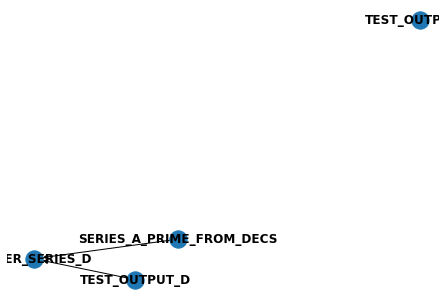

In [9]:
from annotation_driven_dataframe_calcs.annotation_driven_dataframe_calcs import join_registered_series_values

enhanced_result = join_registered_series_values(result)

enhanced_result